# 正态分布随机数的生成

[@jameslao](https://github.com/jameslao) / [www.jlao.net](http://www.jlao.net)

正态分布——听起来非常耳熟，用起来也很顺手——因为很多语言都已经内置了有关正态分布的各种工具。但其实，在这个最普遍、最广泛的正态分布背后，要生成它还有很多学问呢。

$$f(x \; | \; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi} } \; e^{ -\frac{(x-\mu)^2}{2\sigma^2} }$$

(-4, 4, 0, 0.5)

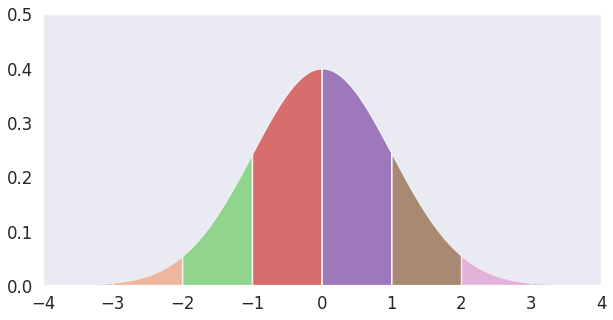

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sigma = 1
mu = 0
sns.set(style="dark", palette="muted", color_codes=True, font_scale=1.5)
x = [np.arange(i - 4, i - 3, 0.01) for i in range(8)]
f = [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x[i] - mu)**2 / (2 * sigma**2) ) for i in range(8)]
alpha = [0.3,0.5,0.7,0.9,0.9,0.7,0.5,0.3]
plt.figure(figsize=(10,5))
for i in range(8):
    plt.fill_between(x[i], 0, f[i], alpha= alpha[i])
plt.axis((-4, 4, 0, 0.5))

难道教科书上没有讲吗？看看概率书上是怎么说的……比如我手头这本浙大版的《概率论与数理统计》（第四版）第 378 页上说……“标准正态变量的分布函数 $\Phi(x)$ 的反函数不存在显式，故不能用逆变换法产生标准正态变量……”

## 反变换法

等下！反函数不存在显式……这都什么年代了，没有解析解难道不能用数值解嘛！求百分位这么常见的动作，怎么会不能做呢？Excel 里面提供了`NORMINV` 函数，R 语言里面有 `qnorm`，在 Python 里面可以用 SciPy.stats 里提供的 `norm.ppf`：

CPU times: user 1.23 s, sys: 763 ms, total: 2 s
Wall time: 2 s


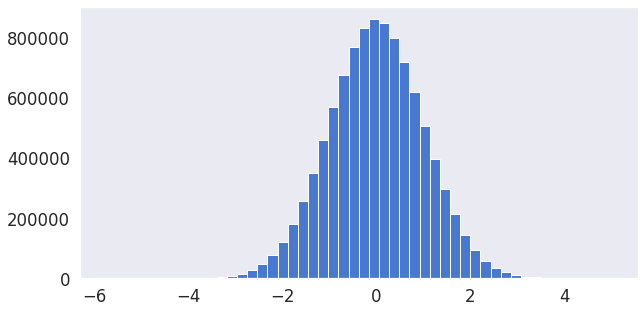

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
N = 10 ** 7
%matplotlib inline
%time x = stats.norm.ppf(np.random.rand(N, 1))
plt.figure(figsize=(10,5))
plt.hist(x,50)
plt.show()

当然……不算快啦，但还是可以凑合用的。这个给高斯积分求逆的实现可以看 [SciPy 的 ndtri() 函数](https://github.com/scipy/scipy/blob/master/scipy/special/cephes/ndtri.c)。这段代码来自于 Cephes 数学库，采用了分段近似的方法但是精度还相当不错——明明是 80 年代末就有了！

这个变换当然很直观啦，如果你再想变回均匀分布，只要再用一次分布函数就好了：

(array([199998., 199574., 200044., 199704., 199574., 200141., 199944.,
        200252., 199955., 200072., 199002., 199774., 200271., 200356.,
        200138., 199969., 200065., 199743., 199762., 200400., 200907.,
        199976., 200448., 199981., 200219., 199619., 199842., 199322.,
        200232., 200700., 199807., 199073., 199608., 199413., 200921.,
        199571., 199583., 199818., 200270., 201388., 199693., 200194.,
        199828., 199490., 200306., 200804., 200609., 200567., 199022.,
        200051.]),
 array([4.07138978e-09, 1.99999989e-02, 3.99999937e-02, 5.99999884e-02,
        7.99999832e-02, 9.99999780e-02, 1.19999973e-01, 1.39999968e-01,
        1.59999962e-01, 1.79999957e-01, 1.99999952e-01, 2.19999947e-01,
        2.39999942e-01, 2.59999936e-01, 2.79999931e-01, 2.99999926e-01,
        3.19999921e-01, 3.39999916e-01, 3.59999910e-01, 3.79999905e-01,
        3.99999900e-01, 4.19999895e-01, 4.39999889e-01, 4.59999884e-01,
        4.79999879e-01, 4.99999874e-01, 5.19999869e-

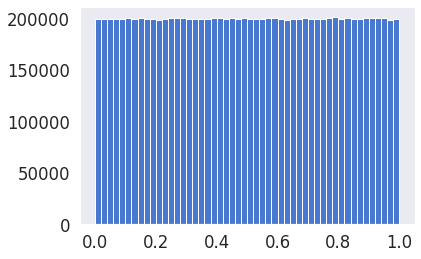

In [4]:
x = stats.norm.cdf(x)
plt.hist(x, 50)

## 中心极限定理……还是不要用的好

那教科书上教的是什么方法呢？它祭出了中心极限定理…… 取 $n$ 个相互独立的均匀分布 $X_i = U(0,1)$，$E(X_i)=\frac{1}{2}$，$\mathrm{Var}(X_i)=\frac{1}{12}$，那么根据中心极限定理，$n$ 比较大的时候近似有

$$Z = \frac{\displaystyle\sum_{i=1}^n X_i - E\left(\displaystyle\sum_{i=1}^n X_i\right)}{\sqrt{\mathrm{Var}\left(\displaystyle\sum_{i=1}^n X_i\right)}}= \frac{\displaystyle\sum_{i=1}^n X_i - \frac{n}{2}}{\sqrt{n} \sqrt{\frac{1}{12}}} \sim N(0,1).$$

取 $n=12$ 则近似有

$$Z = \sum_{i=1}^{12} U_i - 6 \sim N(0,1).$$

这个呢……我们也来试试看

CPU times: user 1.96 s, sys: 555 ms, total: 2.52 s
Wall time: 2.52 s


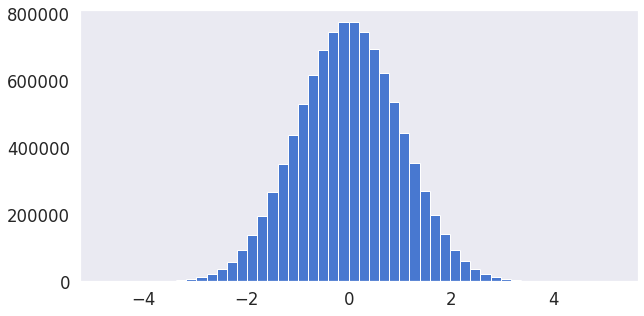

In [5]:
%time g = np.sum(np.random.rand(N, 12), 1) - 6
plt.figure(figsize=(10,5))
plt.hist(g,50)
plt.show()

更慢了。形状倒是有那么点意思。那我们来看看它生成的质量如何：

In [6]:
import scipy.stats as stats
stats.normaltest(g)

NormaltestResult(statistic=4665.739075254162, pvalue=0.0)

竟然可耻地毫无争议地失败了…… (╯‵□′)╯︵┻━┻ 我们的样本数比较大（$10^7$），用仅仅 12 个做平均是很难得到合理的“正态”样本的。可要是取更大的 $n$ 的话，要生成太多的随机数又实在太慢了。如果需要的样本数少一点（比如 1000 个）倒还可以勉强凑合：

In [8]:
stats.normaltest(np.sum(np.random.rand(1000, 12), 1) - 6)

NormaltestResult(statistic=2.999740424803123, pvalue=0.2231591215554297)

好吧，这方法大概只有理论上的意义。我们来看一个比较常用的方法是怎么做的：

## Box-Muller 变换

我们再来看看这个反变换的事。基本上我们的问题就是要计算

$$I = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} \mathrm{d} x$$

大家都知道这个积分没有初等函数的表示。不过呢

$$I^2 = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} \mathrm{d} x \int_{-\infty}^{\infty} e^{-\frac{y^2}{2}} \mathrm{d} y = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} e^{-\frac{x^2+y^2}{2}} \mathrm{d} x \, \mathrm{d} y$$

注意看右边，这个形式让我们想到了……极坐标！令 $x = r\cos\theta$，$y = r\sin\theta$，那么 $\mathrm{d}x\,\mathrm{d}y$ 变成 $\mathrm{d}r\,\mathrm{d}\theta$ 的时候要记得乘上雅各比矩阵：

$$\mathrm{d}x\,\mathrm{d}y = \begin{vmatrix}\frac{\partial x}{\partial r} & \frac{\partial x}{\partial \theta} \\ \frac{\partial y}{\partial r} & \frac{\partial y}{\partial \theta} \end{vmatrix} \mathrm{d}r\,\mathrm{d}\theta= r\, \mathrm{d}r\,\mathrm{d}\theta$$

于是

$$I ^2 = \int_{r=0}^{\infty}\int_{\theta=0}^{2\pi}e^{-\frac{r^2}{2}} r\,\mathrm{d}r\,\mathrm{d}\theta = 2\pi\int_{r=0}^{\infty}e^{-\frac{r^2}{2}} r\,\mathrm{d}r = 2\pi\int_{r=0}^{\infty}e^{-\frac{r^2}{2}} \mathrm{d}\left(\frac{r^2}{2}\right) =2\pi$$ 

有了这个技巧就求出了积分。如果再把反变换方法应用到这里，$\Theta$ 可以均匀地取 $[0,2\pi]$ 中的值，即

$$\Theta = 2\pi U_1$$
还可以同理计算出

$$\mathbb{P}(R\leq r) = \int_{r'=0}^r e^{-\frac{r'^2}{2}}\,r'\,\mathrm{d}r' = 1- e^{-r^2/2}$$

令其满足均匀分布 $1-U_2$，则

$$R = \sqrt{-2\ln(U_2)}$$

因此，只需要产生均匀分布 $U_1$ 和 $U_2$，就可以计算 $R$ 和 $\Theta$，进而计算出 $X$ 和 $Y$ 两个相互独立的正态分布了。

Python 里面的 `random.gauss()` 函数用的就是这样一个实现，但是用它实在太慢了，我们还是靠 NumPy 吧：

CPU times: user 821 ms, sys: 168 ms, total: 989 ms
Wall time: 988 ms


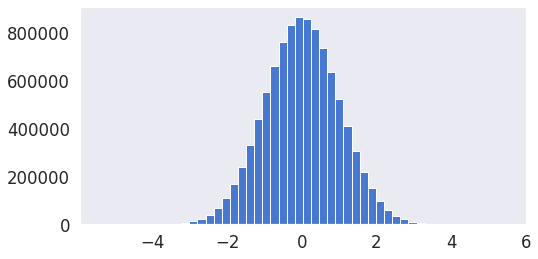

In [9]:
import random
#%time x = [random.gauss(0, 1) for _ in range(N)]
%time x = np.sqrt(-2 * np.log(np.random.rand(N, 1))) * np.cos(2 * np.pi * np.random.rand(N, 1))
plt.figure(figsize=(8, 4))
plt.hist(x, 50)
plt.show()

当然……不是很快。不但是因为 Python 本身的速度，更是因为要计算好多次三角函数。NumPy 里面的 `numpy.random.randn()` 则又做了进一步的优化。代码可以见[这里](https://github.com/numpy/numpy/blob/master/numpy/random/mtrand/randomkit.c)的 `rk_gauss()` 函数。它的原理是这样的：我们要的分布是

$$
\begin{aligned}
X &= R \cos(\Theta) =\sqrt{-2 \ln U_1} \cos(2 \pi U_2)\\
Y &= R \sin(\Theta) =\sqrt{-2 \ln U_1} \sin(2 \pi U_2)
\end{aligned}$$

如果我们产生两个独立的均匀分布 $U_1$ 和 $U_2$，并且**抛弃单位圆之外的点**，那么 $s = U_1^2 + U_2^2$ 也是均匀分布的。为什么呢？因为 

$$f_{U_1,U_2}(u,v) = \frac{1}{\pi}$$

将坐标代换为 $r$ 和 $\theta$，乘上一个雅各比行列式，我们前面算过了这个行列式就等于 $r$，所以：

$$f_{R,\Theta}(r, \theta) = \frac{r}{\pi}$$

$\Theta$ 是均匀分布在 $[0, 2\pi)$ 上的，所以

$$f_R(r) = \int_0^{2\pi} f_{R,\Theta}(r, \theta)\,\mathrm{d}\theta = 2r$$

再做一次变量代换
 
$$f_{R^2}(s) = f_R(r) \frac{\mathrm{d}r}{\mathrm{d}(r^2)} = 2r \cdot \frac{1}{2r} = 1$$

好了，既然 $s$ 也是均匀分布的，那么 $\sqrt{-2 \ln U_1}$ 和 $\sqrt{-2 \ln s}$ 就是同分布的。而又因为

$$\cos \Theta, \sin\Theta = \frac{U_1}{R}, \frac{U_2}{R} = \frac{U_1}{\sqrt{s}}, \frac{U_2}{\sqrt{s}}$$

那么

$$u\sqrt{\frac{-2\ln s}{s}}, v\sqrt{\frac{-2\ln s}{s}}$$

就是我们要找的两个独立正态分布。

CPU times: user 427 ms, sys: 44.7 ms, total: 472 ms
Wall time: 470 ms


(array([1.10000e+01, 2.50000e+01, 5.50000e+01, 1.40000e+02, 3.29000e+02,
        6.87000e+02, 1.53000e+03, 3.00600e+03, 5.89500e+03, 1.10390e+04,
        1.99770e+04, 3.42110e+04, 5.69940e+04, 8.95570e+04, 1.36126e+05,
        1.97685e+05, 2.74507e+05, 3.64938e+05, 4.65034e+05, 5.66482e+05,
        6.64285e+05, 7.45167e+05, 7.99671e+05, 8.24947e+05, 8.13866e+05,
        7.69930e+05, 6.95873e+05, 6.04436e+05, 5.01779e+05, 3.99359e+05,
        3.04901e+05, 2.23912e+05, 1.55886e+05, 1.04550e+05, 6.74900e+04,
        4.21350e+04, 2.46760e+04, 1.40400e+04, 7.41700e+03, 3.94100e+03,
        1.90300e+03, 9.13000e+02, 4.08000e+02, 1.57000e+02, 8.90000e+01,
        2.50000e+01, 9.00000e+00, 4.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([-4.90597334, -4.6987957 , -4.49161807, -4.28444043, -4.07726279,
        -3.87008516, -3.66290752, -3.45572988, -3.24855224, -3.04137461,
        -2.83419697, -2.62701933, -2.4198417 , -2.21266406, -2.00548642,
        -1.79830878, -1.59113115, -1.38395351, -1

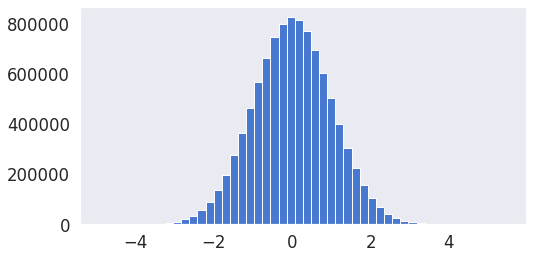

In [10]:
%time x = np.random.randn(N)
plt.figure(figsize=(8,4))
plt.hist(x,50)

这速度还是十分不错的（当然一大原因是 NumPy 是 C 实现的）。本来 Box-Muller 包括 Matlab 在内的各大数值软件所采用的标准正态分布生成方法，直到出现了速度更快的金字塔 (Ziggurat) 方法。NumPy 出于兼容性的考虑迟迟没有更新，导致生成随机数的速度已经落在了 Matlab 和 [Julia](https://github.com/JuliaLang/julia/blob/master/test/perf/kernel/ziggurat.jl) 后面。那么这个神奇的金字塔又是怎么回事呢？我们另开一篇细谈。

## 接受—拒绝法

求反变换固然还可行，但是碰到无法解析求逆的函数，用数值方法总归比较慢。下面我们就来说说另一个能够适合任何概率密度分布的方法——**接受—拒绝法** (Acceptance-Rejection Method)，国内也有翻译成叫做**舍选法**的。接受—拒绝法的思路其实很简单——比如说你想要正态分布，我们就弄个方框框把它框起来，然后均匀地往里面扔飞镖。扔到曲线以下我就留着，扔到曲线以上就不要了。这样搞好以后来看，曲线之下的点就是（二维）均匀分布的。那这些点的**横坐标**就正好满足我们要的分布——高的地方的点就多，低的地方的点就少嘛。

(-4, 4, 0, 0.5)

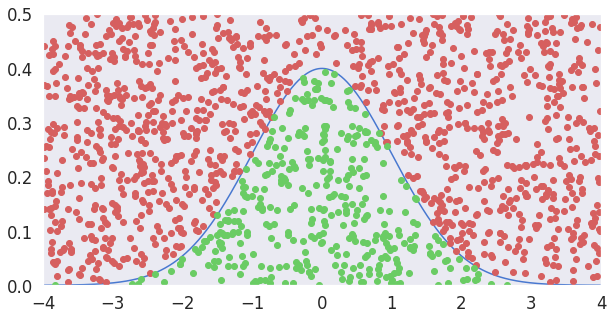

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sigma = 1
mu = 0
sns.set(style="dark", palette="muted", color_codes=True, font_scale=1.5)
x = np.arange(-4,4,0.01)
f = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
Np = 1500
px = np.random.rand(Np) * 8 - 4
py = np.random.rand(Np) * 0.5
pd = py < 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (px - mu)**2 / (2 * sigma**2) )
pu = np.logical_not(pd)
plt.figure(figsize=(10,5))
plt.plot(x, f)
plt.plot(px[pu], py[pu], 'ro', px[pd], py[pd], 'go')
plt.axis((-4, 4, 0, 0.5))

很直观是吧？更普遍来讲，如果要生成一个概率密度为 $f(x)$ 的分布，我们可以

1. 先找到一个容易抽样的辅助分布 $g(x)$（也就是框框，不一定是均匀分布啦），使得存在一个常数 $M>1$，在整个 $x$ 的定义域上都有 $f(x)\leq Mg(x)$。
2. 生成符合 $g(x)$ 分布的随机数 $x$。
3. 生成一个在 $(0,1)$ 上均匀分布的随机数 $u$。
4. 看看是不是满足 $u < f(x)/Mg(x) $。如果满足就保留 $x$，否则就丢弃。于是得到的 $x$ 就符合 $f(x)$ 分布。

实际上这个思路就是生成一堆 $x$ 轴均匀分布，$y$ 轴在 $Mg(x)$ 之内的点，然后仅保留 $f(x)$ 曲线下的那部分，就和我们看到的这个图是一个意思。

要比较严格的证明的话，我们先看看在操作中接受数据点 $x$ 的概率。由于 $u$ 是均匀分布的，所以接受概率

$$\begin{align}
P(\textrm{accept}) & =P\left(U < \frac{f(X)}{Mg(X)}\right) \\
&= \mathbb{E}\left[\frac{f(X)}{Mg(X)}\right]\\
&= \int \frac{f(X)}{Mg(X)} g(x) \mathrm{d}x \\
& =\frac{1}{M}\int f(x)\mathrm{d}x = \frac{1}{M}
\end{align}
$$

也就是说能够保留数据点的概率是 $1/M$。那么利用贝叶斯法则，在接受条件下得到的分布

$$
\begin{align}
g(x|\textrm{accept})  &= \frac{P(\textrm{accept}|X=x)g(x)}{P(\textrm{accept})}\\
&= \frac{\frac{f(x)}{Mg(x)}g(x)}{1/M} = f(x)
\end{align}$$

这东西看起来很美很方便啊，但是请注意，所有的抽样中，被接受的概率只有 $1/M$，意味着如果 $M$ 很大，就有大量的采样被浪费掉了。特别是像正态分布这种尾巴很长的……要是直接用方框框的话，得浪费多少采样才能遇上一个在 $5\sigma$ 之外的啊。为了改进算法的效率，就需要让 $g(x)$ 尽量能够贴近 $f(x)$，于是就有了这个神奇的金字塔 (Ziggurat) 方法。

## Ziggurat 方法

Ziggurat 方法的思路其实也很直观，就是要让 $g(x)$ 尽量贴近 $f(x)$。怎么贴近呢？就像这样：

9.267114853273029e-12


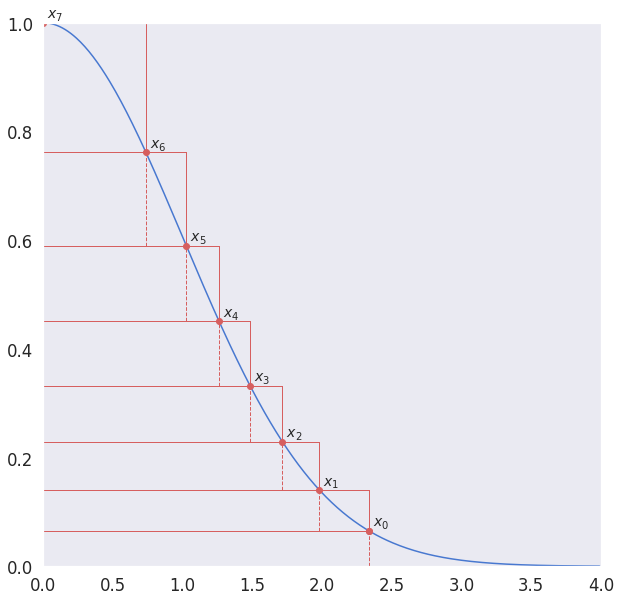

In [21]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
n = 7
f = lambda x : np.exp(- x * x / 2)
fi = lambda f : np.sqrt(-np.log(f) * 2)
def z(r):
    v = r * f(r) + (1 - norm.cdf(r))* np.sqrt(2 * np.pi)
    x = [r]
    for i in range(1, n):
        x.append(fi(v / x[i - 1] + f(x[i - 1])))
    return x[n - 1] *(f(0) - f(x[n - 1])) - v
r = 2.33837169825 # 7
print (z(r))
plt.figure(figsize = (10, 10))
plt.xlim(0,4)
plt.ylim(0,1)
xp = np.arange(0,4, 0.01)
fp = 1 * np.exp( -xp ** 2 / 2 )
v = r * f(r) + (1 - norm.cdf(r)) * np.sqrt(2 * np.pi)
x = [r]
for i in range(1, n):
    x += [fi(v / x[i - 1] + f(x[i - 1]))]
x += [0, r]
y = [f(_) for _ in x]    
plt.plot(xp, fp)
plt.plot(x, y, 'ro')
for i in range(n + 1):
    plt.axhline(y=y[i], xmin=0, xmax=x[i - 1]/4, linewidth=1, color='r')
    plt.axvline(x=x[i], ymin=y[i], ymax=y[i + 1], linewidth=1, color='r')
    plt.axvline(x=x[i], ymin=y[i], ymax=y[i + 1], linewidth=1, color='r')
    plt.axvline(x=x[i], ymin=y[i - 1], ymax=y[i], linewidth=1, color='r', ls = '--')
    plt.annotate('x', xy = (x[i], y[i]), xytext=(x[i]+0.03, y[i] + 0.01), style='italic', size = 14)
    plt.annotate(str(i), xy = (x[i], y[i]), xytext=(x[i]+0.09, y[i] + 0.005), style='normal', size = 10)
plt.axvline(x=x[0], ymin=0, ymax=y[0], linewidth=1, color='r', ls = '--')

是不是像一个有阶梯的金字塔？Ziggurat 这个词最初是说苏美尔人建的金字塔，但是其实玛雅人造的那个奇琴伊察的金字塔看起来也差不多……我前两年去的时候还画了一幅画就像这样

![](http://www.jlao.net/wp-content/uploads/2012/12/cancun3.png)

跑题了……为了计算方便起见，我们生成的是 $e^{-x^2/2}$ 而不是原始的正态分布。首先把图形分成好多个（一般实际中用 128 个或 256 个）阶梯一样的长方块，每个长方块的面积都是相等的，并且还和最下面的带长长的尾巴的这一条的面积相等。这些点的位置……只能靠数值方法了。习惯上把 $x_0$ 的位置叫做参数 $r$，那最下面一块的面积 $v$ 就是虚线左边的长方形面积加上尾巴：

$$v = r\cdot f(r) + \int_r ^\infty f(x) \mathrm{d} x$$

先假定一个 $r$ 值，求出 $v$ 后逐个求到最上面一个 $x_{n-1}$ 的位置，如果最上面一块面积不是 $v$ 再调整 $r$ 直到各块面积相等。

这些块块分好了以后怎么办呢？先不考虑尾巴，它是这样操作的：

1. 随机选定一层 $0 \leq i < n$；
2. 产生一个 $[0,1]$ 的均匀分布的随机数 $U_0$，令 $x = U_0x_i$，也就是随机产生一个均匀分布在实线框中的 $x$ 值。
3. 如果 $x < x_{i+1}$，也就是落在虚线框内，那肯定就在图形之内啦，直接返回 $x$。
4. 否则，那就是落在虚线和实现之间的部分，必须要做个判定了。在这个小框框中随机产生一个 $y$，即先产生一个均匀分布的 $U_1$，令 $y = y_i + U_1(y_{i+1}-y_i)$。
5. 如果 $y <f(x)$，返回 $x$。否则就重新来过。

要是正好选到了尾巴怎么办呢？算法用了一个技巧，它用指数函数来逼近这个尾巴，生成 $x = -\ln(U_0) / r$，$y = -\ln(U_1)$，只要 $2y > x^2$ 就可以返回 $x + r$。

这个方法好就好在，分块的多少只影响速度，不影响精度——因为在每一块中都是经过接受—拒绝的，所以生成的是精确的正态分布，哪怕只用这 8 块也可以。

原始代码可以看[这里](http://www.jstatsoft.org/article/downloadSuppFile/v005i08/rnorrexp.c)，基本思路就是上面说的这些，程序里面用了 SHR3 随机数生成器来生成均匀分布的 32 位整数，把所有需要用于比较的分划点都算好后存起来，并且用了一些位操作来提高效率。我把它移植到了 Python 上，配合 NumPy 使用，可以去 [GitHub](https://github.com/jameslao/zignor-python) 上下载，或者直接 `pip install zignor` 就可以啦！

来看下速度

Wall time: 93.1 ms


NormaltestResult(statistic=1.1365384917237324, pvalue=0.56650507170017939)

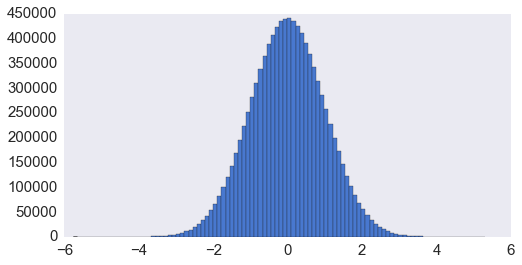

In [24]:
import numpy as np
import zignor
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
N = 10**7
%time x = zignor.randn(N)
plt.figure(figsize=(8,4))
plt.hist(x,100)
stats.normaltest(x)

比 Box-Muller 变换快了四倍呢！哇咔咔咔~